In [849]:
try:
  # Install colab required dependencies
  import google.colab
  !pip install -q tf-agents
except:
  pass

In [850]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import math

import tensorflow as tf
from tf_agents.networks import q_network
from tf_agents.agents.dqn import dqn_agent
from tf_agents.agents.ddpg import ddpg_agent, critic_network, actor_network, critic_rnn_network, actor_rnn_network
from tf_agents.specs import tensor_spec, array_spec
from tf_agents.environments import py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.policies import random_tf_policy
from tf_agents import utils
from tf_agents.trajectories import time_step as ts

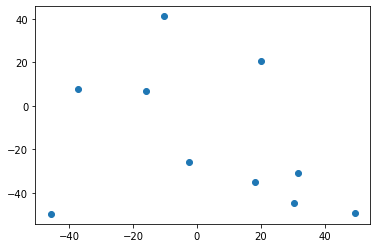

In [851]:
# Number of sensing locations
locations_num = 10

# Size of the map (the map is squared)
map_size = 100.0

# Coordinates of the sensing locations
sensing_locations = (np.random.rand(locations_num, 2) * map_size) - (map_size / 2)

_ = plt.scatter(sensing_locations[:,0], sensing_locations[:,1])

In [852]:
# Number of drones
drones_num = 5

# Length of a single cycle in seconds
cycle_length = 1.0

# Maximum speed of drones in points / seconds
max_speed = 5.0

# Definition of the global state

# Coordinates of the drones locations
drones_locations = np.zeros((drones_num, 2), dtype=float)

# Amounts of sensing data to send per drone
sensing_data_amounts = np.zeros(drones_num, dtype=float)

# AoIs (age of information) per sensing location. Denotes the last cycle in which
# any drone performed sensing at a specific sensing location
aois = np.zeros(locations_num, dtype=int)

# Indices of the chosen locations per drone. They are chosen in the decision cycles.
# The initial values are not significant.
chosen_locations = np.zeros(drones_num, dtype=int)

# Stage of the cycle for every drone
# 0 -> decision, 1 -> empty, 2 -> sensing, 3 -> transmission
cycle_stages = np.zeros(drones_num, dtype=int)

# Current cycle
current_cycle = [0]


# Returns the AoI of the given location
def get_location_aoi(cycle, location_index):
    return (cycle * cycle_length) - ((aois[location_index] // cycle_length) * cycle_length)

# Returns the accumulated AoI (of all the sensing locations)
def get_accumulated_aoi(cycle):
    return max([sum([get_location_aoi(cycle, location) for location in range(locations_num)]), 0.0001])

# Returns the trajectory for the current cycle 
def get_trajectory(drone_index):
    chosen_location_index = chosen_locations[drone_index]
    chosen_location = sensing_locations[chosen_location_index]
    drone_location = drones_locations[drone_index]
    distance = np.linalg.norm(chosen_location - drone_location)
    if distance <= max_speed * cycle_length:
        return chosen_location - drone_location
    else:
        return ((chosen_location - drone_location) / distance) * max_speed * cycle_length

# Resets all the AoIs to 0
def reset_aois():
    for i in range(locations_num): aois[i] = 0

# Resets all the drones locations to 0, 0
def reset_drones_locations():
    for i in range(drones_num): drones_locations[i] = np.array([0.0,0.0])

In [853]:
# Simplifying transmission step: only considering a bandwidth and a total amount of
# data for every location. Assumption: tasks are equal, so the amount of data is the same.

# Transmission bandwidth per cycle
bandwidth = 0.5

# Total amount of sensing data per location
total_location_data = 1.5

# Amount of data transmissible per cycle 
data_transmission_cycle = bandwidth * cycle_length

In [854]:
# Agents definition

'''
Using Deep Q Learning. Having current drone location (x,y), 
potential sensing location (x',y') (could also directly consider distance
between the two locations) and AoI of the sensing location
as features, the network should output a Q value. The higher
the value the better this sensing location choice. Executing the network
at the decision cycle for every sensing location and choosing the one
that outputs the highest Q value. After each decision, the Q network
should be updated by performing backpropagation and considering the error.
'''


class DurpEnv(py_environment.PyEnvironment):
    def __init__(self, drone):
        self._drone = drone
        self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=locations_num-1, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(shape=(2,),
            minimum=(-map_size//2), maximum=(map_size//2), dtype=np.float64)
        


    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):

        return ts.restart(np.array([0.0,0.0], dtype=np.float64))

    def _step(self, action):
        '''
        if self._episode_ended:
            # The last action ended the episode. Ignore the current action and start
            # a new episode.
            return self.reset()
        '''

        # Performing next step

        #print(current_cycle[0])

        chosen_location_index = int(action)

        accumulated_aoi = get_accumulated_aoi(current_cycle[0])

        # Updating AoI of chosen destination
        aois[chosen_location_index] = current_cycle[0]

        # Calculating reward considering new accumulated AoI (sum of AoIs) 
        # and distance from chosen location
        new_accumulated_aoi = get_accumulated_aoi(current_cycle[0])

        aoi_multiplier = 0.05

        # Using sigmoid function to obtain a value between 0 and 1. The 
        # higher the aoi difference the better, so the higher
        # the reward.
        normalized_diff_aoi_component = \
            ((1/(1+np.exp(- (accumulated_aoi - new_accumulated_aoi) * aoi_multiplier))) - 0.5) * 2.0


        # Taking distance between current location and chosen location
        chosen_location = sensing_locations[chosen_location_index]
        drone_location = drones_locations[self._drone]
        distance = np.linalg.norm(chosen_location - drone_location)

        distance_multiplier = 0.03

        # Normalizing distance
        # between 0 and 1. The smaller the distance, the higher the reward.
        normalized_location_distance = (1 - (1/(1+np.exp(-distance * distance_multiplier)))) * 2.0

        # Computing reward using weights
        aoi_weight = 1.0
        distance_weight = 0.0
        reward = normalized_diff_aoi_component * aoi_weight + normalized_location_distance * distance_weight + np.random.random() * (1.0 - aoi_weight - distance_weight)

        #print("Action: ", action)
        #print("Reward: ", normalized_diff_aoi_component)

        
        #self.cycle += 8

        return ts.transition(chosen_location, reward=reward)

        
learning_rate = 0.001

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

environments = []
agents = []
for drone in range(drones_num):

    durp_env = DurpEnv(drone)

    train_env = tf_py_environment.TFPyEnvironment(durp_env)

    '''
    actor_rnn_net = actor_rnn_network.ActorRnnNetwork(
        train_env.observation_spec(), 
        train_env.action_spec()
    )

    critic_rnn_net = critic_rnn_network.CriticRnnNetwork(
        (train_env.observation_spec(), train_env.action_spec()), 
        lstm_size=[10,5,2]
        #output_activation_fn=tf.keras.activations.sigmoid,
        #activation_fn=tf.nn.relu
    )

    actor_net = actor_network.ActorNetwork(
        train_env.observation_spec(), 
        train_env.action_spec()
    )

    critic_net = critic_network.CriticNetwork(
        (train_env.observation_spec(), train_env.action_spec()), 
        #output_activation_fn=tf.keras.activations.sigmoid,
        #activation_fn=tf.nn.relu
    )'''

    
    q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec())

    '''
    agent = ddpg_agent.DdpgAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    critic_network=critic_rnn_net,
    actor_network=actor_rnn_net,
    critic_optimizer=optimizer,
    actor_optimizer=optimizer,
    #td_errors_loss_fn=utils.common.element_wise_squared_loss,
    #train_step_counter=tf.Variable(0)
    )
    '''

    train_step_counter = tf.Variable(0)

    agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    #td_errors_loss_fn=utils.common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

    agent.initialize()
    agents.append(agent)
    environments.append(train_env)


def get_best_action(drone):

    highest_reward = 0
    best_action = 0

    for action in range(locations_num):

        chosen_location_index = action


        aoi = get_location_aoi(current_cycle[0], chosen_location_index)



        aoi_multiplier = 0.05

        # Using sigmoid function to obtain a value between 0 and 1. The 
        # higher the aoi difference the better, so the higher
        # the reward.
        normalized_diff_aoi_component = \
            ((1/(1+np.exp(- aoi * aoi_multiplier))) - 0.5) * 2.0


        # Taking distance between current location and chosen location
        chosen_location = sensing_locations[chosen_location_index]
        drone_location = drones_locations[drone]
        distance = np.linalg.norm(chosen_location - drone_location)

        distance_multiplier = 0.03

        # Normalizing distance
        # between 0 and 1. The smaller the distance, the higher the reward.
        normalized_location_distance = (1 - (1/(1+np.exp(-distance * distance_multiplier)))) * 2.0



        aoi_weight = 1.0
        distance_weight = 0.0
        reward = normalized_diff_aoi_component * aoi_weight + normalized_location_distance * distance_weight + np.random.random() * (1.0 - aoi_weight - distance_weight)

        if reward >= highest_reward:
            best_action = chosen_location_index
            highest_reward = reward

    return best_action


In [855]:
# Training step

num_iterations = 10 # @param {type:"integer"}

intermediate_iterations = 300

eval_interval = 10

initial_collect_steps = 1 # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}

def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    #while not time_step.is_last():
    for m in range(10):
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

def collect_step(environment, policy, buffer, drone, iteration):
  time_step = environment.current_time_step()

  best_action = get_best_action(drone)

  action_step = policy.action(time_step)
  if np.random.random() < (iteration /num_iterations):
      action_step = action_step.replace(action=tf.constant([best_action], dtype=np.int32))
  else:
      action_step = action_step.replace(action=tf.constant([random.randrange(locations_num)], dtype=np.int32))
  #print(action_step.action)

  next_time_step = environment.step(action_step.action)
  #next_time_step = environment.step(best_action)
  
  drones_locations[drone] = next_time_step.observation
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps, drone, iteration):
  for step in range(1, steps + 1):
    current_cycle[0] = step
    collect_step(env, policy, buffer, drone, iteration)




replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
        data_spec=agents[0].collect_data_spec,
        batch_size=environments[0].batch_size)

random_policy = random_tf_policy.RandomTFPolicy(environments[0].time_step_spec(),
                                            environments[0].action_spec())
                                            
reset_aois()
reset_drones_locations()

collect_data(environments[0], random_policy, replay_buffer, initial_collect_steps, 0, 0)

reset_aois()
reset_drones_locations()


dataset = replay_buffer.as_dataset(
num_parallel_calls=3, 
sample_batch_size=batch_size, 
num_steps=2).prefetch(3)
iterator = iter(dataset)
    
# Reset the train step

returns = np.zeros((drones_num, (num_iterations // eval_interval) + 1), dtype=np.float64)
for k in range(len(agents)):

  avg_return = compute_avg_return(environments[k], agents[k].policy)
  returns[k][0] = avg_return

for i in range(num_iterations):
  
    reset_aois()
    reset_drones_locations()

    if i % 100 == 0:        
        print("----------------", i)

    for j in range(intermediate_iterations):

      for k in range(len(agents)):
        agent = agents[k]
        env = environments[k]
        
        # Collect a few steps using collect_policy and save to the replay buffer.
        collect_data(env, agent.collect_policy, replay_buffer, collect_steps_per_iteration, k, i)
        
      
    for k in range(len(agents)):
        agent = agents[k]

        # Sample a batch of data from the buffer and update the agent's network.
        experience, unused_info = next(iterator)
        train_loss = agent.train(experience).loss

        print("Loss:", train_loss)

    
    if i % eval_interval == 0:
      for k in range(len(agents)):
        agent = agents[k]

        avg_return = compute_avg_return(environments[k], agent.policy)
        returns[k][(num_iterations//eval_interval)] = avg_return



Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
---------------- 0
Loss: tf.Tensor(3.163754, shape=(), dtype=float32)
Loss: tf.Tensor(5.722932, shape=(), dtype=float32)
Loss: tf.Tensor(3.730577, shape=(), dtype=float32)
Loss: tf.Tensor(2.757555, shape=(), dtype=float32)
Loss: tf.Tensor(7.2097893, shape=(), dtype=float32)
Loss: tf.Tensor(3.2469454, shape=(), dtype=float32)
Loss: tf.Tensor(4.8487415, shape=(), dtype=float32)

In [856]:
# Simulation

time_steps = []
for drone in range(drones_num):
    time_steps.append(environments[drone].reset())

# Number of total cycles for the simulation
cycles_num = 200

reset_aois()
reset_drones_locations()

# Running simulation (one cycle at a time for every drone)
for cycle in range(1, cycles_num + 1):

    #print(aois)
    if cycle % 10 == 1:
        #print(drones_locations)
        print(get_accumulated_aoi(cycle))
        print(aois)
        print("----------------")
    for drone in range(drones_num):
        #aoi = get_location_aoi(cycle, chosen_locations[drone])
        # if aoi == cycle_length:
        #print(cycle_stages[drone])
        if cycle_stages[drone] == 0:  # Decision cycle
            agent = agents[drone]
            env = environments[drone]
            current_cycle[0] = cycle
            #print(cycle, agent.cycle)
            #print( drones_locations[drone])
            policy_step = \
                agent.policy.action(time_steps[drone]) 
                # (action: , state: )
            new_step = env.step(policy_step.action)
            #print(time_steps[drone])
            time_steps[drone] = new_step
            #print(time_steps[drone])
            #print(new_step.reward)
            #print(int(policy_step.action))
            #print(sensing_locations[chosen_locations[drone]])
            chosen_locations[drone] = int(policy_step.action)
            cycle_stages[drone] =  1
        elif (drones_locations[drone] != sensing_locations[chosen_locations[drone]]).all(): # Empty cycle
            #print( drones_locations[drone])
            traj = get_trajectory(drone)
            new_location = drones_locations[drone] + traj
            # Updating drone location
            drones_locations[drone] = new_location
        elif sensing_data_amounts[drone] == 0.0: # Sensing cycle
            cycle_stages[drone] =  2
            # Updating drone sensing data remaining amount
            sensing_data_amounts[drone] = total_location_data
            cycle_stages[drone] =  3
        else: # Transmission cycle
            # Updating drone sensing data remaining amount
            sensing_data_amounts[drone] = \
                np.max([sensing_data_amounts[drone] - data_transmission_cycle, 0.0])
            # Updating the AoI if the transmission has been completed
            if sensing_data_amounts[drone] == 0.0:
                #aois[chosen_locations[drone]] = cycle
                cycle_stages[drone] =  0

10.0
[0 0 0 0 0 0 0 0 0 0]
----------------
107.0
[0 1 0 0 0 0 0 0 1 1]
----------------
135.0
[20  1  0 20  0  0 14  0  1 19]
----------------
216.0
[29  1  0 20  0  0 14  0  1 29]
----------------
296.0
[39  1  0 20  0  0 14  0  1 39]
----------------
345.0
[49  1  0 20  0  0 45  0  1 49]
----------------
425.0
[59  1  0 20  0  0 45  0  1 59]
----------------
461.0
[69  1  0 64  0  0 45  0  1 69]
----------------
512.0
[79  1  0 64  0  0 74  0  1 79]
----------------
583.0
[89  1  0 64  0  0 83  0  1 89]
----------------
663.0
[99  1  0 64  0  0 83  0  1 99]
----------------
684.0
[109   1   0 102   0   0 104   0   1 109]
----------------
764.0
[119   1   0 102   0   0 104   0   1 119]
----------------
827.0
[129   1   0 102   0   0 121   0   1 129]
----------------
856.0
[139   1   0 140   0   0 134   0   1 139]
----------------
936.0
[149   1   0 140   0   0 134   0   1 149]
----------------
991.0
[159   1   0 140   0   0 159   0   1 159]
----------------
1066.0
[169   1   0 140   

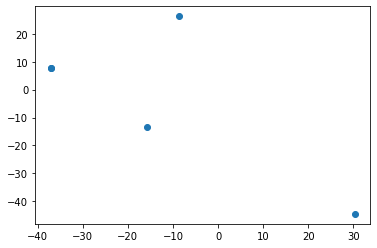

In [857]:
_ = plt.scatter(drones_locations[:,0], drones_locations[:,1])